In [1]:
import sys
sys.path.insert(0,'..')
import numpy as np
import pydensecrf.densecrf as dcrf

from cv2 import imread, imwrite

from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian

In [2]:
class fullprint:
    'context manager for printing full numpy arrays'

    def __init__(self, **kwargs):
        if 'threshold' not in kwargs:
            kwargs['threshold'] = np.nan
        self.opt = kwargs

    def __enter__(self):
        self._opt = np.get_printoptions()
        np.set_printoptions(**self.opt)

    def __exit__(self, type, value, traceback):
        np.set_printoptions(**self._opt)

# with fullprint():
#     print(a)        

In [3]:
fn_im = 'im2.png'
fn_anno = 'anno2.png'
fn_output = 'test.png'

In [4]:
img = imread(fn_im)
img.shape

(213, 320, 3)

In [5]:
# Convert the annotation's RGB color to a single 32-bit integer color 0xBBGGRR
anno_rgb = imread(fn_anno).astype(np.uint32)
anno_lbl = anno_rgb[:,:,0] + (anno_rgb[:,:,1] << 8) + (anno_rgb[:,:,2] << 16)
anno_lbl.shape

(213, 320)

/home/shhs/Desktop/user/soft/anaconda3/envs/tf_1_6/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


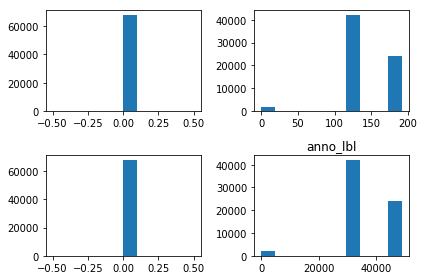

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(anno_rgb[:, :, 0].ravel())
ax1.hist(anno_rgb[:, :, 1].ravel())
ax2.hist(anno_rgb[:, :, 2].ravel())
ax3.hist(anno_lbl.ravel())
ax3.set_title('anno_lbl')
fig.tight_layout()
fig.show()

In [7]:
# Convert the 32bit integer color to 1, 2, ... labels.
# Note that all-black, i.e. the value 0 for background will stay 0.
colors, labels = np.unique(anno_lbl, return_inverse=True)
print(colors)
print(labels.shape)
labels

[    0 32768 49152]
(68160,)


array([1, 1, 1, ..., 1, 1, 1])

In [8]:
# But remove the all-0 black, that won't exist in the MAP!
HAS_UNK = 0 in colors
if HAS_UNK:
    print("Found a full-black pixel in annotation image, assuming it means 'unknown' label, and will thus not be present in the output!")
    print("If 0 is an actual label for you, consider writing your own code, or simply giving your labels only non-zero values.")
    colors = colors[1:]
print(colors)

Found a full-black pixel in annotation image, assuming it means 'unknown' label, and will thus not be present in the output!
If 0 is an actual label for you, consider writing your own code, or simply giving your labels only non-zero values.
[32768 49152]


In [9]:
# And create a mapping back from the labels to 32bit integer colors.
colorize = np.empty((len(colors), 3), np.uint8)
colorize[:,0] = (colors & 0x0000FF)
colorize[:,1] = (colors & 0x00FF00) >> 8
colorize[:,2] = (colors & 0xFF0000) >> 16
colorize

array([[  0, 128,   0],
       [  0, 192,   0]], dtype=uint8)

In [10]:
# Compute the number of classes in the label image.
# We subtract one because the number shouldn't include the value 0 which stands
# for "unknown" or "unsure".
n_labels = len(set(labels.flat)) - int(HAS_UNK)
print(n_labels, " labels", (" plus \"unknown\" 0: " if HAS_UNK else ""), set(labels.flat))

2  labels  plus "unknown" 0:  {0, 1, 2}


In [11]:
###########################
### Setup the CRF model ###
###########################

print("Using generic 2D functions")

# Example using the DenseCRF class and the util functions
d = dcrf.DenseCRF(img.shape[1] * img.shape[0], n_labels)

# get unary potentials (neg log probability)
U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=HAS_UNK)
d.setUnaryEnergy(U)

# This creates the color-independent features and then add them to the CRF
feats = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features and then add them to the CRF
feats = create_pairwise_bilateral(sdims=(80, 80), schan=(13, 13, 13),
                                  img=img, chdim=2)
d.addPairwiseEnergy(feats, compat=10,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)


Using generic 2D functions


In [12]:
####################################
### Do inference and compute MAP ###
####################################

# Run five inference steps.
Q = d.inference(5)

In [13]:
# Find out the most probable class for each pixel.
MAP = np.argmax(Q, axis=0)

In [14]:
# Convert the MAP (labels) back to the corresponding colors and save the image.
# Note that there is no "unknown" here anymore, no matter what we had at first.
MAP = colorize[MAP,:]
imwrite(fn_output, MAP.reshape(img.shape))

True

In [19]:
# Just randomly manually run inference iterations
Q, tmp1, tmp2 = d.startInference()
for i in range(5):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)


KL-divergence at 0: -474644.65885096736
KL-divergence at 1: -698790.8267423583
KL-divergence at 2: -766858.5600422554
KL-divergence at 3: -771025.2255776466
KL-divergence at 4: -771661.582425735
